In [1]:
%%writefile walidacja_funkcji.py
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, fsolve
import numpy as np

"""
    Zwykly greisen
    Ne(t)= 0.31 / sqrt(ln(E0/Ec)) *  exp[t( 1 - 3/2 ln(s))]
    
    t - distance the shower has developed [radiation length]
    E0 - primary energy (of a particle?)
    Ec - critical energy (of material?)
    Ne(t) - number of particles in electromagnetic shower
    s - shower age, s = 3t / (t + 2 * ln(E0/Ec))
"""

def greisen(t: np.ndarray | float, E0: float = 1e3, Ec: float = 21.8):
    """
        E0 - energia poczatkowa czastki [tutaj w MeV]
        Ec - energia typowa dla materialu [MeV]
    """
    beta0 = np.log(E0 / Ec)
    if isinstance(t, float):
        if t < 0.:
            return 0.0
        else:
            s = 3*t /(t + 2*beta0)
            return 0.31 / np.sqrt(beta0) * np.exp(t * (1 - 1.5 * np.log(s)))
    else:
        valid = t > 0
        result = np.zeros_like(t, dtype=float) # jak t nie ma sensu fizycznego to 0
        
        if np.any(valid):
            t_valid = t[valid]
            s = 3*t_valid / (t_valid + 2*beta0)
            result[valid] = 0.31 / np.sqrt(beta0) * np.exp(t_valid * (1 - 1.5 * np.log(s)))
        
        return result



def NKG(r: float, r_m: float = 79, s: float = 1, r_min: float = 1):
    """
    r - distance from the main axis
    r_m - Molier radius: for earth 79 meters at the sea level or 91 meters above the ground
    s - shower age allegedly 0 < s < 2 but the maximum is for s = 1
    r_min - a point where equation stops working
    r_max - where the equation stops working
    """
    r_max = 50 * r_m
    
    if isinstance(r, (float, int)):
        if r < 0.0:
            return 0.0
        if r < r_min:
            r = r_min
        if r > r_max:
            r = r_max
        r_ratio = r / r_m
        return (r_ratio) ** (s - 2) * (1 + r_ratio) ** (s - 4.5)
    
    elif isinstance(r, np.ndarray):
        r = r.copy()  # unikamy modyfikacji oryginalnej tablicy
        r[r < r_min] = r_min
        r[r > r_max] = r_max
        r_ratio = r / r_m
        return np.where(r_ratio >= 0.0, (r_ratio) ** (s - 2) * (1 + r_ratio) ** (s - 4.5), 0.0)


def jakis_rozklad(x):
    return np.exp(-(3 * x**4 - 2 * x**2))


def metropolis_hastings_probing(distribution: callable, length: int):
    x_actual = 0.1
    xs = np.zeros(length)
    ys = np.zeros(length)
    added = 0

    while added < length:
        x_proposed = x_actual + np.random.normal(loc=0, scale=1)
        ys[added] = distribution(x_proposed)
        prob_adding = ys[added] / distribution(x_actual) # te rozklady nie zaleza od polozenia poprzedniego punktu

        if np.random.uniform(low=0., high=1.) <= prob_adding: # w teorii powinno byc min(1, prob_adding) ale to nic nie zmienia w praktyce
            x_actual = x_proposed
        else:
            ys[added] = ys[added-1]
        xs[added] = x_actual
        added += 1

    return xs, ys


def rejection_sampling_probing(distribution: callable, length: int, epsilon: int, looking_x_left: int = -1, looking_x_right: int = 1):
    """
        epsilon - zwroci takie x dla ktorych f(x) > epsilon
        X0 - charakterystyczna wartosc dla danego materialu - dlugosc radiacji
    """
    xs = []

    minimized_function = minimize_scalar(lambda x: -distribution(x), method='brent') # moze wylazic na liczby urojone to trzeba by sprawdzic
    max_value = -minimized_function.fun # trzeba znalezc maksymalna wartosc dystrubucji
    from_x = fsolve(lambda x: distribution(x) - epsilon, looking_x_left)
    to_x = fsolve(lambda x: distribution(x) - epsilon, looking_x_right)
    
    while len(xs) < length:
        X = np.random.uniform(from_x, to_x, size=length)
        u = np.random.uniform(0, max_value, size=length)
        samples = X[u <= distribution(X)]
        if len(xs) + len(samples) >= length:
            xs.extend(samples[:length - len(xs)])
        else:
            xs.extend(samples)
        
    xs = np.array(xs)
    return xs, distribution(xs)

Overwriting walidacja_funkcji.py


/home/mamusiaarusia/praktyki/walidacja_funkcji.py:103: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  from_x = fsolve(lambda x: distribution(x) - epsilon, looking_x_left)


Liczba probek metropolis=100000, rejection-sampling=100000


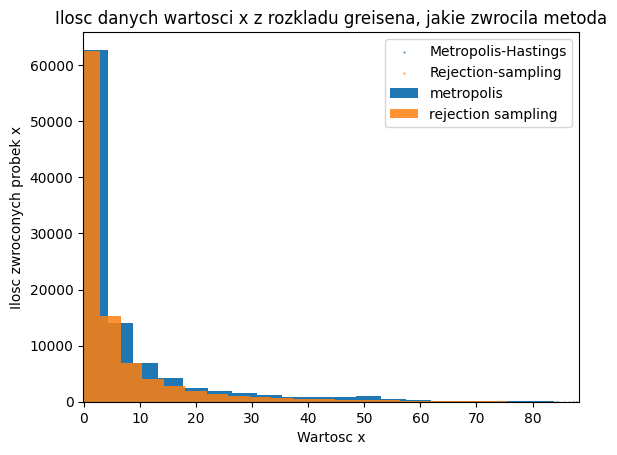

In [3]:
from walidacja_funkcji import *

x_mh, y_mh = metropolis_hastings_probing(NKG, 100_000)
x_rs, y_rs = rejection_sampling_probing(NKG, 100_000, 0.1)

print(f'Liczba probek metropolis={len(x_mh)}, rejection-sampling={len(x_rs)}')

plt.title(rf'Probkowanie Metropolisem-Hastingsem tego rozkladu greisena ${1e3:.0e}$ MeV')
plt.scatter(x_mh, y_mh, s=0.2, label='Metropolis-Hastings')
plt.scatter(x_rs, y_rs, s=0.2, label='Rejection-sampling')
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.legend()
plt.xlim(-0.1, max(np.max(x_mh), np.max(x_rs)))
plt.savefig('./Wykresy/Walidacja/NKG_z_mh_rs.jpg')

plt.title('Ilosc danych wartosci x z rozkladu greisena, jakie zwrocila metoda')
plt.hist(x_mh, bins=20, label='metropolis')
plt.hist(x_rs, bins=20, label='rejection sampling', alpha=0.85)
plt.legend()
plt.xlabel('Wartosc x')
plt.ylabel('Ilosc zwroconych probek x')
plt.savefig('./Wykresy/Walidacja/czestosc_dla_NKG.jpg')

len(x_rs)=10000, len(x_mh)=10000


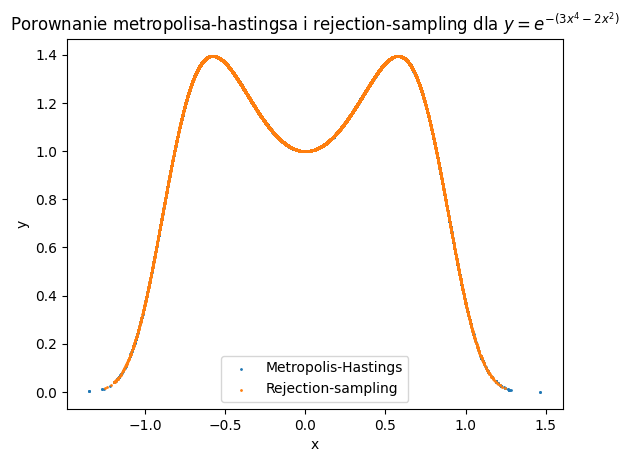

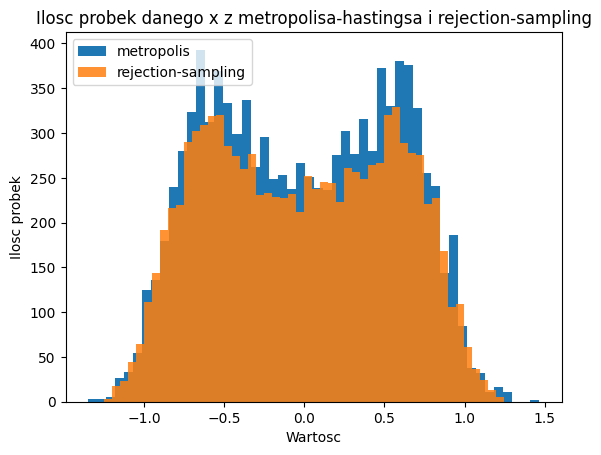

In [5]:
from walidacja_funkcji import *

X0 = 1.757 # cm https://pdg.web.cern.ch/pdg/2020/AtomicNuclearProperties/HTML/iron_Fe.html

x_mh, y_mh = metropolis_hastings_probing(jakis_rozklad, 10_000)
x_rs, y_rs = rejection_sampling_probing(jakis_rozklad, 10_000, 0.01)

print(f'{len(x_rs)=}, {len(x_mh)=}')

plt.title(r'Porownanie metropolisa-hastingsa i rejection-sampling dla $y = e^{-(3x^4 - 2x^2)}$')
plt.scatter(x_mh, y_mh, label='Metropolis-Hastings', s=1)
plt.scatter(x_rs, y_rs, label='Rejection-sampling', s=1)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('./Wykresy/Walidacja/porownanie_moj_rozklad.jpg')

plt.figure()
plt.title('Ilosc probek danego x z metropolisa-hastingsa i rejection-sampling')
plt.hist(x_mh, bins=50, label='metropolis')
plt.hist(x_rs, bins=50, label='rejection-sampling', alpha=0.85)
plt.legend()
plt.xlabel('Wartosc')
plt.ylabel('Ilosc probek')
plt.savefig('./Wykresy/Walidacja/porownanie_moj_rozklad_histogram.jpg')

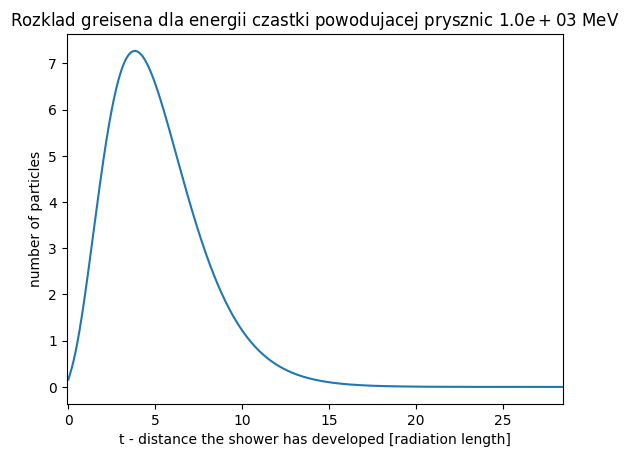

In [6]:
t_prob = np.linspace(1e-10, 50, num=10_000) / X0 # jak daleko przeszedl dzielone przez dlugosc radiacyjna dla zelaza
values = greisen(t_prob)

plt.title(rf'Rozklad greisena dla energii czastki powodujacej prysznic ${1e3:.1e}$ MeV')
plt.plot(t_prob, values)
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.xlim(-0.1, np.max(t_prob))
plt.savefig('./Wykresy/Walidacja/Rozklad_Greisena.jpg')

/home/mamusiaarusia/praktyki/walidacja_funkcji.py:27: RuntimeWarning: divide by zero encountered in log
  return 0.31 / np.sqrt(beta0) * np.exp(t * (1 - 1.5 * np.log(s)))
/home/mamusiaarusia/praktyki/walidacja_funkcji.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  return 0.31 / np.sqrt(beta0) * np.exp(t * (1 - 1.5 * np.log(s)))
/home/mamusiaarusia/praktyki/walidacja_funkcji.py:90: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  to_x = fsolve(lambda x: distribution(x) - epsilon, looking_x_right)


Liczba probek metropolis=10000, rejection-sampling=10000


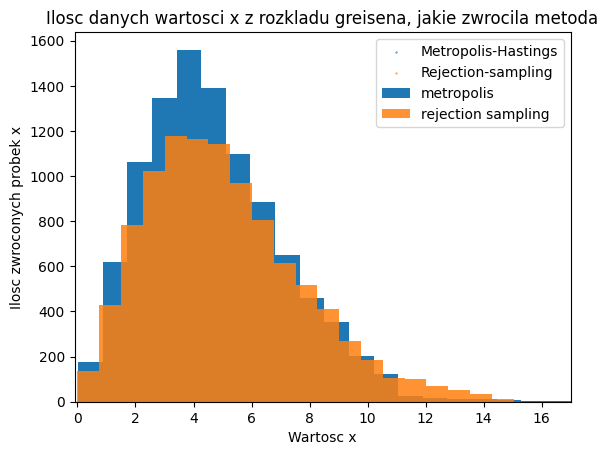

In [7]:
x_mh, y_mh = metropolis_hastings_probing(greisen, 10_000)
x_rs, y_rs = rejection_sampling_probing(greisen, 10_000, 0.1)

print(f'Liczba probek metropolis={len(x_mh)}, rejection-sampling={len(x_rs)}')

plt.title(rf'Probkowanie Metropolisem-Hastingsem tego rozkladu greisena ${1e3:.0e}$ MeV')
plt.scatter(x_mh, y_mh, s=0.2, label='Metropolis-Hastings')
plt.scatter(x_rs, y_rs, s=0.2, label='Rejection-sampling')
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.legend()
plt.xlim(-0.1, max(np.max(x_mh), np.max(x_rs)))
plt.savefig('./Wykresy/Walidacja/greisen_z_rs_i_mh.jpg')

plt.title('Ilosc danych wartosci x z rozkladu greisena, jakie zwrocila metoda')
plt.hist(x_mh, bins=20, label='metropolis')
plt.hist(x_rs, bins=20, label='rejection sampling', alpha=0.85)
plt.legend()
plt.xlabel('Wartosc x')
plt.ylabel('Ilosc zwroconych probek x')
plt.savefig('./Wykresy/Walidacja/czestosc_x_dla_greisena.jpg')

/home/mamusiaarusia/praktyki/walidacja_funkcji.py:89: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  from_x = fsolve(lambda x: distribution(x) - epsilon, looking_x_left)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

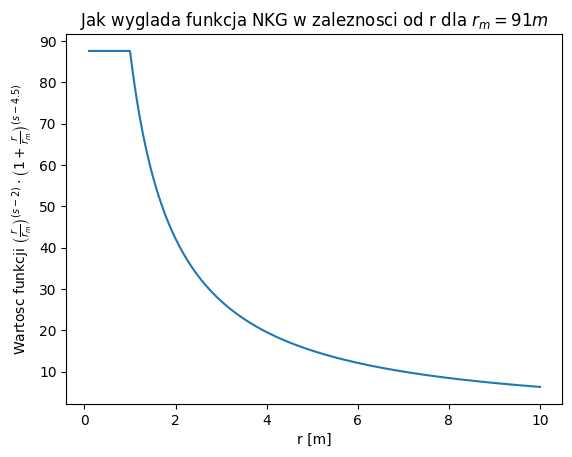

In [ ]:
r_m = 91 
rs = np.linspace(0.1, 10, num=1_000)
s = 1

f = []

for r in rs:
    f.append( NKG(r, r_m, s) )

f = np.array(f)
plt.title(r'Jak wyglada funkcja NKG w zaleznosci od r dla $r_m = 91$ m')
plt.xlabel('r [m]')
plt.ylabel(r'Wartosc funkcji $\left(\frac{r}{r_m}\right)^{(s - 2)} \cdot \left(1 + \frac{r}{r_m}\right)^{(s - 4.5)}$')
plt.plot(rs, f)
plt.savefig('./Wykresy/Walidacja/NKG.jpg')